## **Graph Based Evaluation and Benchmark**

The original function evaluation in `impedance.py` and `nleis.py` relies on string parsing and the use of `eval()`, which can become slow for complex circuits and large inputs of parameters and frequencies. To address this, we have introduced a graph-based function evaluation that improves performance significantly, achieving at least a 3X speedup in certain applications.

The following example demonstrates the implementation and provides benchmark results comparing the graph-based approach to the eval()-based evaluation.

In [19]:
from nleis import NLEISCustomCircuit, EISandNLEIS
import timeit
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tabulate import tabulate

warnings.filterwarnings("ignore")

### **Enable Graph-based Calculation**

The graph-based evalution has been seamleassly built into `EISandNELIS` and `NLEISCustomCircuit`. The user can easily enable it by set `graph = True` in the circuit initialization. Beside this, all other method remains the same and can be used as usual.

#### Example for NLEISCustomCircuit

In [20]:
circ_str = 'd(TDSn0,TDSn1)'
initial_guess = [
        5e-3, 1e-3, 10, 1e-2, 100, 10, 0.1,
        # TDS0 + additioal nonlinear parameters
        1e-3, 1e-3, 1e-3, 1e-2, 1000, 1, 0.01,
        # TDS1 + additioal nonlinear parameters
    ]
circuit = NLEISCustomCircuit(circ_str, initial_guess=initial_guess,graph=True)

Once the circuit has been initialized, it is possible to retreieve the graph by calling `circuit.cg`. Once nice thing about the graph is that it is visualizable, which can be achieved using the `.visualize_graph` method.  

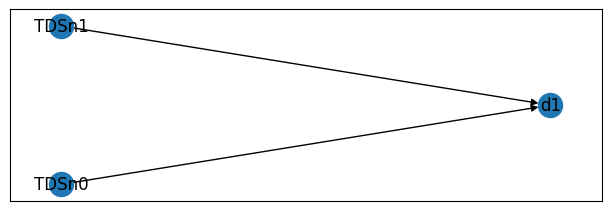

In [21]:
f, ax = plt.subplots(figsize=(6,2), layout="constrained")
circuit.cg.visualize_graph(ax=ax)

#### Example for EISandNLEIS

The graph initialization follows the same logic for `EISandNLEIS` class. The only difference is that graph are initialized separately for EIS and NLEIS circuit.

In [22]:
circ_str_1 = 'L0-R0-TDS0-TDS1'
circ_str_2 = 'd(TDSn0,TDSn1)'
initial_guess = [1e-7, 1e-3,  # L0,RO
                    5e-3, 1e-3, 10, 1e-2, 100, 10, 0.1,
                    # TDS0 + additioal nonlinear parameters
                    1e-3, 1e-3, 1e-3, 1e-2, 1000, 1, 0.01,
                    # TDS1 + additioal nonlinear parameters
                    ]
simul_circuit = EISandNLEIS(circ_str_1, circ_str_2,
                            initial_guess=initial_guess, graph=True)

EIS and NLEIS graph can be extracted separately by calling `simul_circuit.cg1` and `simul_circuit.cg2` respectively

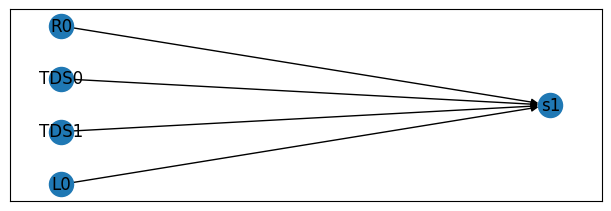

In [23]:
f, ax = plt.subplots(figsize=(6,2), layout="constrained")
simul_circuit.cg1.visualize_graph(ax=ax)

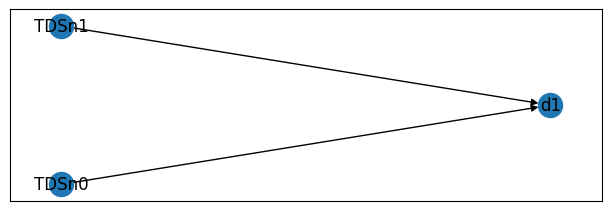

In [24]:
f, ax = plt.subplots(figsize=(6,2), layout="constrained")
simul_circuit.cg2.visualize_graph(ax=ax)

### **Speed Benchmark**

To benchamrk the performance of graph based calculation, We consider the three different types of model that are typically used in EIS and 2nd-NLEIS analysis. 

This includes: 
- simple RC circuits
- simple porous electrode model
- TLM model (requires matrix calculation). 

The parameters are chosen to be simple for ths benchmark.

In each cases, two scenarios are considered:
- Scenario 1: `f = np.geomspace(1e-3,1e4,100)`, representing the typical range and number of frequencies used in impedance measurements   
- Scenario 2: `f = np.geomspace(1e-5,1e5,int(1e4))`, representing impractical high-resolution measurements.

Lastly, We also compare the speed of calculation with respect to directly calling these functions.



#### **Simple RC Circuit**

In [25]:
from nleis.nleis_elements_pair import RC
p = [1,1]

##### Scenario 1

In [26]:
f = np.geomspace(1e-3,1e4,100)
def time_dirct_cal():
    return RC(p,f)
direct_time_RC_s1 = timeit.timeit(time_dirct_cal, number=10)

eval_circuit = NLEISCustomCircuit(
        'RC', initial_guess=p, graph=False)
graph_circuit = NLEISCustomCircuit(
    'RC', initial_guess=p, graph=True)

def time_predict_eval():
    return eval_circuit.predict(f, max_f=np.inf)

def time_predict_graph():
    return graph_circuit.predict(f, max_f=np.inf)

eval_time_RC_s1 = timeit.timeit(time_predict_eval, number=10)
graph_time_RC_s1 = timeit.timeit(time_predict_graph, number=10)

print(f'direct_time: {direct_time_RC_s1},\neval_time: {eval_time_RC_s1},\ngraph_time: {graph_time_RC_s1}')
print(f'eval_time/direct_time: {eval_time_RC_s1/direct_time_RC_s1},\ngraph_time/direct_time: {graph_time_RC_s1/direct_time_RC_s1}')
print(f'eval_time/graph_time: {eval_time_RC_s1/graph_time_RC_s1}')


direct_time: 0.00043966699740849435,
eval_time: 0.0029851250001229346,
graph_time: 0.0008621250162832439
eval_time/direct_time: 6.789513467506083,
graph_time/direct_time: 1.960859062346779
eval_time/graph_time: 3.462519870948968


##### Scenario 2

In [27]:
f = np.geomspace(1e-5,1e5,int(1e4))
def time_dirct_cal():
    return RC(p,f)
direct_time_RC_s2 = timeit.timeit(time_dirct_cal, number=10)

eval_circuit = NLEISCustomCircuit(
        'RC', initial_guess=p, graph=False)
graph_circuit = NLEISCustomCircuit(
    'RC', initial_guess=p, graph=True)

def time_predict_eval():
    return eval_circuit.predict(f, max_f=np.inf)

def time_predict_graph():
    return graph_circuit.predict(f, max_f=np.inf)

eval_time_RC_s2 = timeit.timeit(time_predict_eval, number=10)
graph_time_RC_s2 = timeit.timeit(time_predict_graph, number=10)

print(f'direct_time: {direct_time_RC_s2},\neval_time: {eval_time_RC_s2},\ngraph_time: {graph_time_RC_s2}')
print(f'eval_time/direct_time: {eval_time_RC_s2/direct_time_RC_s2},\ngraph_time/direct_time: {graph_time_RC_s2/direct_time_RC_s2}')
print(f'eval_time/graph_time: {eval_time_RC_s2/graph_time_RC_s2}')


direct_time: 0.01712454200605862,
eval_time: 0.24936924999929033,
graph_time: 0.016025250020902604
eval_time/direct_time: 14.562097480391834,
graph_time/direct_time: 0.9358060504761477
eval_time/graph_time: 15.56102086856832


#### **Porous Electrode**

In [28]:
from nleis.nleis_elements_pair import TP
p = [1,1,1]

##### Scenario 1

In [29]:
f = np.geomspace(1e-3,1e4,100)

def time_dirct_cal():
    return TP(p,f)
direct_time_P_s1 = timeit.timeit(time_dirct_cal, number=10)

eval_circuit = NLEISCustomCircuit(
        'TP', initial_guess=p, graph=False)
graph_circuit = NLEISCustomCircuit(
    'TP', initial_guess=p, graph=True)

def time_predict_eval():
    return eval_circuit.predict(f, max_f=np.inf)

def time_predict_graph():
    return graph_circuit.predict(f, max_f=np.inf)

eval_time_P_s1 = timeit.timeit(time_predict_eval, number=10)
graph_time_P_s1 = timeit.timeit(time_predict_graph, number=10)

print(f'direct_time: {direct_time_P_s1},\neval_time: {eval_time_P_s1},\ngraph_time: {graph_time_P_s1}')
print(f'eval_time/direct_time: {eval_time_P_s1/direct_time_P_s1},\ngraph_time/direct_time: {graph_time_P_s1/direct_time_P_s1}')
print(f'eval_time/graph_time: {eval_time_P_s1/graph_time_P_s1}')


direct_time: 0.0007940419891383499,
eval_time: 0.002853000012692064,
graph_time: 0.0008623329922556877
eval_time/direct_time: 3.5930089991688985,
graph_time/direct_time: 1.0860042718791778
eval_time/graph_time: 3.3084667272548582


##### Scenario 2

In [30]:
f = np.geomspace(1e-5,1e5,int(1e4))

def time_dirct_cal():
    return TP(p,f)
direct_time_P_s2 = timeit.timeit(time_dirct_cal, number=10)

eval_circuit = NLEISCustomCircuit(
        'TP', initial_guess=p, graph=False)
graph_circuit = NLEISCustomCircuit(
    'TP', initial_guess=p, graph=True)

def time_predict_eval():
    return eval_circuit.predict(f, max_f=np.inf)

def time_predict_graph():
    return graph_circuit.predict(f, max_f=np.inf)

eval_time_P_s2 = timeit.timeit(time_predict_eval, number=10)
graph_time_P_s2 = timeit.timeit(time_predict_graph, number=10)

print(f'direct_time: {direct_time_P_s2},\neval_time: {eval_time_P_s2},\ngraph_time: {graph_time_P_s2}')
print(f'eval_time/direct_time: {eval_time_P_s2/direct_time_P_s2},\ngraph_time/direct_time: {graph_time_P_s2/direct_time_P_s2}')
print(f'eval_time/graph_time: {eval_time_P_s2/graph_time_P_s2}')


direct_time: 0.018269459018483758,
eval_time: 0.23237816599430516,
graph_time: 0.01989183301338926
eval_time/direct_time: 12.71948806799376,
graph_time/direct_time: 1.08880251972782
eval_time/graph_time: 11.682089118578999


#### **Transmission Line Model**

In [31]:
from nleis.nleis_elements_pair import TLMn
p = [1,1,1,1,1,10,0.1,0.2]


##### Scenario 1

In [32]:
f = np.geomspace(1e-3,1e4,100)
def time_dirct_cal():
    return TLMn(p,f)
direct_time_TLM_s1 = timeit.timeit(time_dirct_cal, number=10)

eval_circuit = NLEISCustomCircuit(
        'TLMn', initial_guess=p, graph=False)
graph_circuit = NLEISCustomCircuit(
    'TLMn', initial_guess=p, graph=True)

def time_predict_eval():
    return eval_circuit.predict(f, max_f=np.inf)

def time_predict_graph():
    return graph_circuit.predict(f, max_f=np.inf)

eval_time_TLM_s1 = timeit.timeit(time_predict_eval, number=10)
graph_time_TLM_s1 = timeit.timeit(time_predict_graph, number=10)

print(f'direct_time: {direct_time_TLM_s1},\neval_time: {eval_time_TLM_s1},\ngraph_time: {graph_time_TLM_s1}')
print(f'eval_time/direct_time: {eval_time_TLM_s1/direct_time_TLM_s1},\ngraph_time/direct_time: {graph_time_TLM_s1/direct_time_TLM_s1}')
print(f'eval_time/graph_time: {eval_time_TLM_s1/graph_time_TLM_s1}')


direct_time: 0.12619937499403022,
eval_time: 0.16212762499344535,
graph_time: 0.13549716700799763
eval_time/direct_time: 1.2846943576472918,
graph_time/direct_time: 1.0736754204559826
eval_time/graph_time: 1.1965388544535096


##### Scenario 2

In [33]:
f = np.geomspace(1e-5,1e5,int(1e4))
def time_dirct_cal():
    return TLMn(p,f)
direct_time_TLM_s2 = timeit.timeit(time_dirct_cal, number=10)

eval_circuit = NLEISCustomCircuit(
        'TLMn', initial_guess=p, graph=False)
graph_circuit = NLEISCustomCircuit(
    'TLMn', initial_guess=p, graph=True)

def time_predict_eval():
    return eval_circuit.predict(f, max_f=np.inf)

def time_predict_graph():
    return graph_circuit.predict(f, max_f=np.inf)

eval_time_TLM_s2 = timeit.timeit(time_predict_eval, number=10)
graph_time_TLM_s2 = timeit.timeit(time_predict_graph, number=10)

print(f'direct_time: {direct_time_TLM_s2},\neval_time: {eval_time_TLM_s2},\ngraph_time: {graph_time_TLM_s2}')
print(f'eval_time/direct_time: {eval_time_TLM_s2/direct_time_TLM_s2},\ngraph_time/direct_time: {graph_time_TLM_s2/direct_time_TLM_s2}')
print(f'eval_time/graph_time: {eval_time_TLM_s2/graph_time_TLM_s2}')


direct_time: 12.843668707995676,
eval_time: 17.604674500005785,
graph_time: 15.474227416008944
eval_time/direct_time: 1.3706889285493795,
graph_time/direct_time: 1.2048136531562548
eval_time/graph_time: 1.1376771212366168


#### **Summary**

The following table provides a summary of the benchmark results.

It is evident that graph-based evaluation can achieve at least a **3X speed-up** in typical calculations involving NumPy-oriented circuit functions such as `RC` and `TP`. 

However, for matrix-oriented circuit functions like `TLMn`, graph-based evaluation shows limited performance gains, likely due to the matrix-solving operations dominating the computation time in such cases

In [34]:
table = [["RC S1",direct_time_RC_s1,eval_time_RC_s1,graph_time_RC_s1,eval_time_RC_s1/direct_time_RC_s1,graph_time_RC_s1/direct_time_RC_s1,eval_time_RC_s1/graph_time_RC_s1],
         ["RC S2",direct_time_RC_s2,eval_time_RC_s2,graph_time_RC_s2,eval_time_RC_s2/direct_time_RC_s2,graph_time_RC_s2/direct_time_RC_s2,eval_time_RC_s2/graph_time_RC_s2],
         ["P S1",direct_time_P_s1,eval_time_P_s1,graph_time_P_s1,eval_time_P_s1/direct_time_P_s1,graph_time_P_s1/direct_time_P_s1,eval_time_P_s1/graph_time_P_s1],
         ["P S2",direct_time_P_s2,eval_time_P_s2,graph_time_P_s2,eval_time_P_s2/direct_time_P_s2,graph_time_P_s2/direct_time_P_s2,eval_time_P_s2/graph_time_P_s2],
         ["TLM S1",direct_time_TLM_s1,eval_time_TLM_s1,graph_time_TLM_s1,eval_time_TLM_s1/direct_time_TLM_s1,graph_time_TLM_s1/direct_time_TLM_s1,eval_time_TLM_s1/graph_time_TLM_s1],
         ["TLM S2",direct_time_TLM_s2,eval_time_TLM_s2,graph_time_TLM_s2,eval_time_TLM_s2/direct_time_TLM_s2,graph_time_TLM_s2/direct_time_TLM_s2,eval_time_TLM_s2/graph_time_TLM_s2],]
print(tabulate(table,headers=["Condition","Direct Cal [s]", "eval() [s]", 'graph [s]', 'eval/direct', 'graph/direct', 'eval/graph']))

Condition      Direct Cal [s]    eval() [s]     graph [s]    eval/direct    graph/direct    eval/graph
-----------  ----------------  ------------  ------------  -------------  --------------  ------------
RC S1             0.000439667    0.00298513   0.000862125        6.78951        1.96086        3.46252
RC S2             0.0171245      0.249369     0.0160253         14.5621         0.935806      15.561
P S1              0.000794042    0.002853     0.000862333        3.59301        1.086          3.30847
P S2              0.0182695      0.232378     0.0198918         12.7195         1.0888        11.6821
TLM S1            0.126199       0.162128     0.135497           1.28469        1.07368        1.19654
TLM S2           12.8437        17.6047      15.4742             1.37069        1.20481        1.13768
